<h1 style="text-align:center;font-size:35px;">Predicting stock price movements</h1>

<br>

**In this project I have dealt with the problem of predicting whether a stock's price would move up or down, i.e, a binary classification problem.**

**The data used for this project is :-**

- **Daily stock price data - OHLC, Adj Close etc**
- **Daily Nifty50 index data**
- **Daily BankNifty data (or sectorwise index data e.g : NiftyIT etc)**

**I have collected all data using Yahoo Finance API.**

## Importing necessary libraries

In [1]:
import os
import time
import datetime
import numpy as np
import pandas as pd
# For seeing all columns
pd.set_option('max_columns', None)

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# For dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ML model classes
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras import backend as K

# For cross-validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# For replication of results
np.random.seed(2021)

# Check whether machine has GPU
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

## Fetching historical data

In [2]:
par_dir = r"C:\Users\smitr\Desktop\FinPython\data\nifty50"
file_name = "SBIN.csv"
full_file_path = os.path.join(par_dir, file_name)

par_dir_nifty = r"C:\Users\smitr\Desktop\FinPython\data"
file_name = "NIFTY_17Sep07_09Nov20.csv"
full_file_path_niftySpot = os.path.join(par_dir_nifty, file_name)

file_name = "NiftyBank_17Sep07_06Nov20.csv"
full_file_path_bankNftySpot = os.path.join(par_dir_nifty, file_name)

df = pd.read_csv(full_file_path)
df.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2007-12-03,221.341003,217.755005,219.839996,219.345001,10122532.0,65.268867
1,2007-12-04,221.240997,217.199005,219.557007,218.406006,8591649.0,64.989471
2,2007-12-05,226.350998,218.080994,218.518997,224.983002,12728929.0,66.946533


In [3]:
def target_transform(x):
    if x > 0:
        return 1
    else:
        return 0

In [4]:
df["return"] = df["Open"] - df["Close"]
df["ret_pct"] = (df["Open"] - df["Close"]) / df["Open"]
df["Target"] = df["return"].apply(target_transform)
df.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close,return,ret_pct,Target
0,2007-12-03,221.341003,217.755005,219.839996,219.345001,10122532.0,65.268867,0.494995,0.002252,1
1,2007-12-04,221.240997,217.199005,219.557007,218.406006,8591649.0,64.989471,1.151001,0.005242,1
2,2007-12-05,226.350998,218.080994,218.518997,224.983002,12728929.0,66.946533,-6.464005,-0.029581,0


## Exploratory data analysis :-

<br>

**This is done to know more about the nature of the data. I have also used it to find features which may be important for the prediction task.**

In [5]:
df_cpy = df.copy()

### i) Do we have balanced data ?

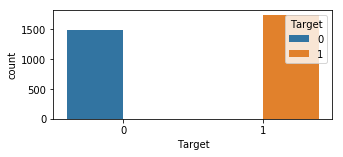

In [6]:
plt.figure(figsize=(5,2))
sns.countplot(x="Target", hue="Target", data=df)

**Observation :-** The data is almost balanced.

### ii) Can weekday be used as a feature ?

**Would stock prices be affected if it is a Wednesday or Thursday ? ,i.e, here I want to find whether nature of weekday has any impact on stock prices.**

In [7]:
def find_weekday_from_date(date):
    
    year, month, day = (int(i) for i in date.split('-'))
    date = datetime.date(year, month, day)
    
    return date.strftime("%A")

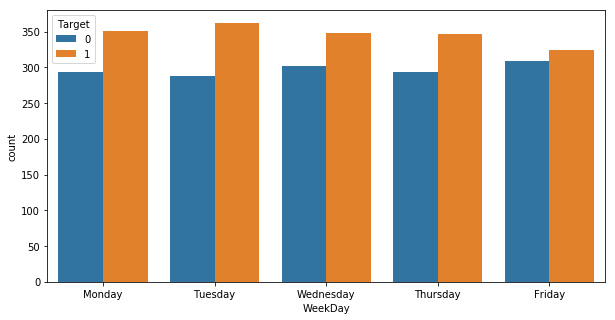

In [10]:
df_cpy["WeekDay"] = df_cpy["Date"].apply(find_weekday_from_date)
plt.figure(figsize=(10,5))
sns.countplot(x="WeekDay", hue="Target", data=df_cpy)

**Observation :-** All days have identical distribution, i.e, there is no day in which the difference between the target variables is highly significant. 

**Inference :-** Thus day of the week wont be an effective feature.

### iii) Can day of the month be used as a feature ?


**Would stock prices be affected if it is 18th or 19th day of the month ? ,i.e, here I want to find whether nature of day of the month has any impact on stock prices.**

In [8]:
def get_month_day(date):
    return int(date.split("-")[2])

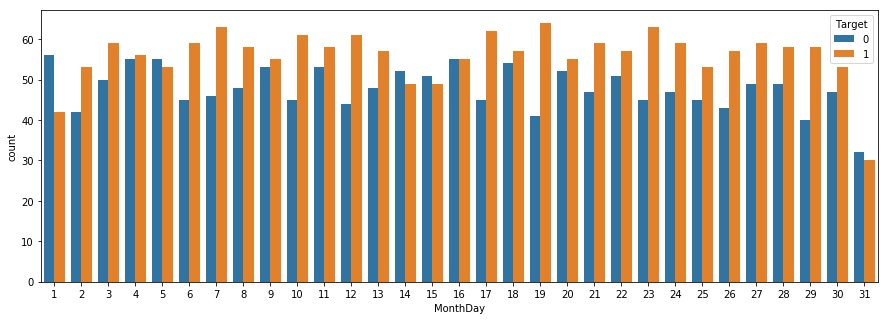

In [9]:
df_cpy["MonthDay"] = df_cpy["Date"].apply(get_month_day)
plt.figure(figsize=(15,5))
sns.countplot(x="MonthDay", hue="Target", data=df_cpy)

**Observation :-** This plot is more interesting, the distributions aren't identical & for some days we see high difference between the categories. E.g :- On 17th, 19th of every month, the stock moves up for significant no.of times. On 1st of every month the stock moves down most no.of times.

**Inference :-** Thus, day of month can be used as a feature.

### iv) Can month be used as a feature ?

In [9]:
def get_month(date):
    return int(date.split("-")[1])

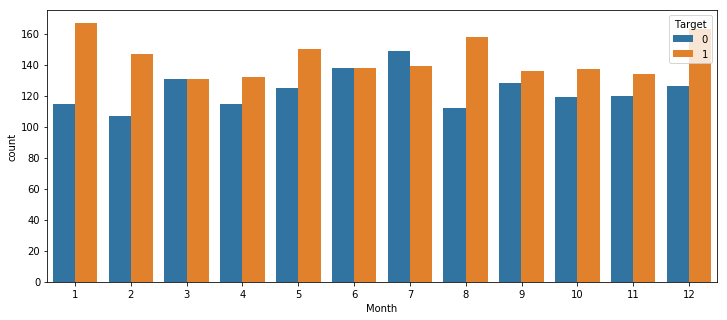

In [11]:
df_cpy["Month"] = df_cpy["Date"].apply(get_month)
plt.figure(figsize=(12,5))
sns.countplot(x="Month", hue="Target", data=df_cpy)

**Observation :-** This plot is also interesting, we have different distributions for different months, E.g:- In the month of January it is seen that the stock moves up quite significant no.of times.

**Inference :-** Thus, month can be used as a feature.

### v) Does previous return affect today's return :-

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

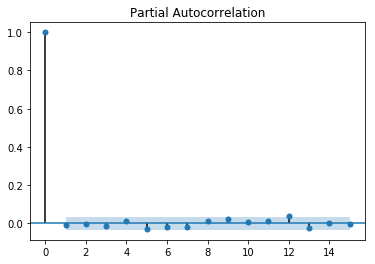

In [13]:
pacf_plot = plot_pacf(df_cpy["return"], lags=15)

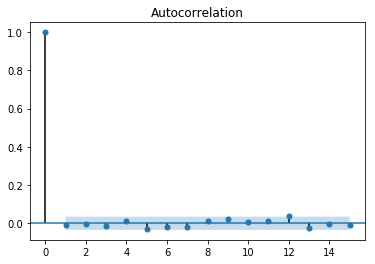

In [14]:
acf_plot = plot_acf(df_cpy["return"], lags=15)

## vi) Can moving crossovers be used ?

**Here I want to check whether previous day's difference between moving averages can give us any clue about any current price changes.**

In [3]:
df_cpy['20ma'] = df_cpy['Close'].rolling(window=20, min_periods=20).mean()
df_cpy['50ma'] = df_cpy['Close'].rolling(window=50, min_periods=50).mean()

df_cpy['3ma'] = df_cpy['Close'].rolling(window=3, min_periods=3).mean()
df_cpy['5ma'] = df_cpy['Close'].rolling(window=5, min_periods=5).mean()

df_cpy['20_50_diff'] = df_cpy['20ma'] - df_cpy['50ma']
df_cpy['3_5_diff'] = df_cpy['3ma'] - df_cpy['5ma']

df_cpy.head(2)

,Date,High,Low,Open,Close,Volume,Adj Close,20ma,50ma,3ma,5ma,20_50_diff,3_5_diff
0,2007-12-03,221.341003,217.755005,219.839996,219.345001,10122532.0,65.268867,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-12-04,221.240997,217.199005,219.557007,218.406006,8591649.0,64.989471,NaN,NaN,NaN,NaN,NaN,NaN


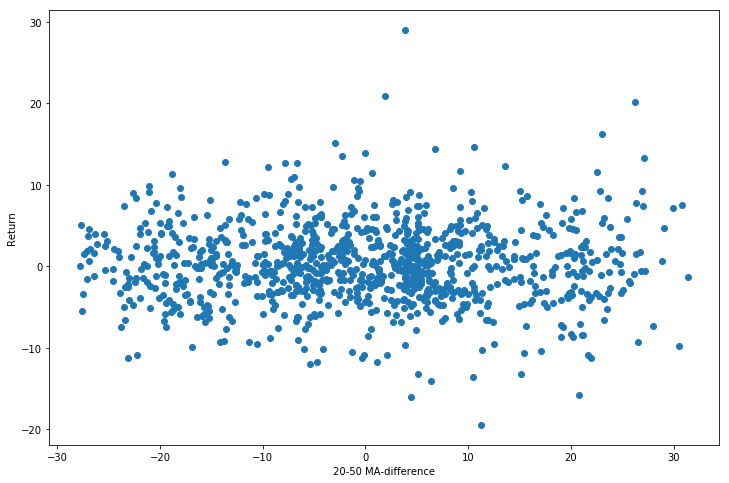

In [10]:
df_cpy["20_50_diff"] = df_cpy["20_50_diff"].shift(periods=1)
df_cpy["3_5_diff"] = df_cpy["3_5_diff"].shift(periods=1)
df_cpy["ret_pct"] = df_cpy["ret_pct"].shift(periods=1)
df_cpy.dropna(inplace=True)

plt.figure(figsize=(12,8))
plt.scatter(df_cpy["20_50_diff"].values[:1000], df_cpy["return"].values[:1000])
plt.xlabel("20-50 MA-difference")
plt.ylabel("Return")
plt.show()

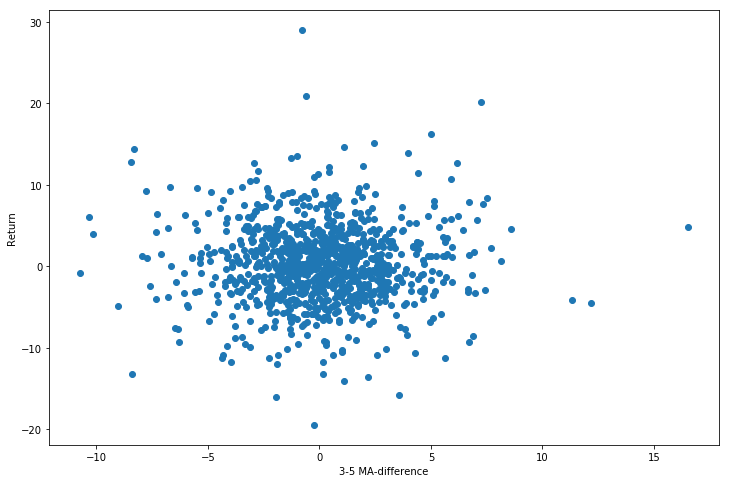

In [11]:
plt.figure(figsize=(12,8))
plt.scatter(df_cpy["3_5_diff"].values[:1000], df_cpy["return"].values[:1000])
plt.xlabel("3-5 MA-difference")
plt.ylabel("Return")
plt.show()

**Observation :-** No interesting pattern noted.

**Inference :-** This feature may not be so effective.

### vii) Using previous high & low :-

I had created 2 features :-

- **(Current open - Previous high)** :- If today's open is greater than previous high then it shows **positive sentiment** & might suggest that today's close will be higher than today's open.
- **(Current open - Previous low)** :- If today's open is lesser than previous low then it shows **negative sentiment** & might suggest that today's close will be lower than today's open.

In [10]:
# Previous high - Current open
df_cpy["hi_op_diff"] = df_cpy["Open"] - df_cpy["High"].shift(periods=1)
# Previous low - Current open
df_cpy["lo_op_diff"] = df_cpy["Open"] - df_cpy["Low"].shift(periods=1)

df_cpy.head(2)

,Date,High,Low,Open,Close,Volume,Adj Close,return,ret_pct,Target,hi_op_diff,lo_op_diff
0,2007-12-03,221.341003,217.755005,219.839996,219.345001,10122532.0,65.268867,0.494995,0.002252,1,NaN,NaN
1,2007-12-04,221.240997,217.199005,219.557007,218.406006,8591649.0,64.989471,1.151001,0.005242,1,-1.783997,1.802002


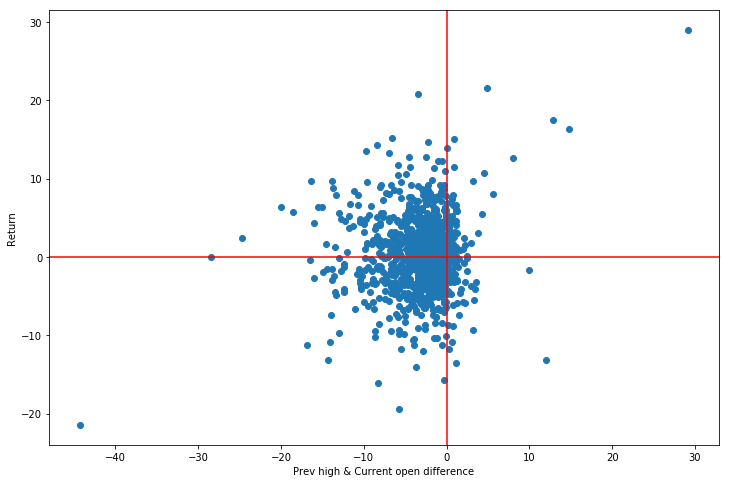

In [11]:
plt.figure(figsize=(12,8))
plt.scatter(df_cpy["hi_op_diff"].values[1:1000], df_cpy["return"].values[1:1000])
plt.axvline(x = 0, color = 'r', label = 'axvline - full height')
plt.axhline(y = 0, color = 'r', linestyle = '-') 
plt.xlabel("Prev high & Current open difference")
plt.ylabel("Return")
plt.show()

**Observation :-** The two red lines in the above plot have divided it into 4 parts :- 

- **Lower left :-** The datapoints here show that the day started & ended negatively.
- **Upper left :-** The datapoints here show an anomaly.
- **Lower right :-** The datapoints here show an anomaly.
- **Upper right :-** The datapoints here show that the day started & ended positively.

**Inference :-** This also wouldn't be an effective feature.

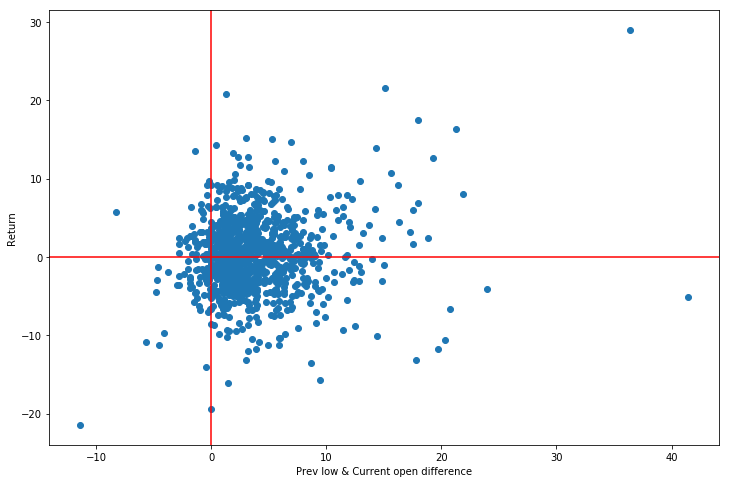

In [12]:
plt.figure(figsize=(12,8))
plt.scatter(df_cpy["lo_op_diff"].values[1:1000], df_cpy["return"].values[1:1000])
plt.axvline(x = 0, color = 'r', label = 'axvline - full height')
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.xlabel("Prev low & Current open difference")
plt.ylabel("Return")
plt.show()

## Feature Engineering :-

<br>

**I plan to use 5 features for the prediction task :-**

- **Stock gap :-** (Previous day's close - Today's open)
- **Nifty50 index gap :-** (Previous day's close spot - Today's open spot price)
- **BankNifty index (or sectorwise index) gap :-** (Previous day's close spot - Today's open spot price)
- **Day of the month :-** Encoding day of the month using some technique.
- **Month :-** Encoding month using some technique.

In [7]:
# Gap up/down of stock price gives a view about current sentiment regarding stock
df["Stock_gap"] = df["Open"] - df["Close"].shift(periods=1)
#df["prev3_Target"] = df["Target"].shift(periods=3)

# Using day of month as a feature
df["MonthDay"] = df["Date"].apply(get_month_day)

# Using month as a feature
df["Month"] = df["Date"].apply(get_month)

# Nifty spot gap up/down
df_nfty_spot = pd.read_csv(full_file_path_niftySpot)
df_nfty_spot["NiftySpot_gap"] = df_nfty_spot["Open"] - df_nfty_spot["Close"].shift(periods=1)

# Sector-wise gap up/down
df_bankNfty_spot = pd.read_csv(full_file_path_bankNftySpot)
df_bankNfty_spot["BankNiftySpot_gap"] = df_bankNfty_spot["Open"] - df_bankNfty_spot["Close"].shift(periods=1)

# Merging data frames
df = pd.merge(df, df_nfty_spot[["Date", "NiftySpot_gap"]], on="Date")
df = pd.merge(df, df_bankNfty_spot[["Date", "BankNiftySpot_gap"]], on="Date")

# Dropping rows with NaN values
df.dropna(inplace=True)

df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,return,ret_pct,Target,Stock_gap,MonthDay,Month,NiftySpot_gap,BankNiftySpot_gap
1,2007-12-04,221.240997,217.199005,219.557007,218.406006,8591649.0,64.989471,1.151001,0.005242,1,0.212006,4,12,5.200195,6.600586
2,2007-12-05,226.350998,218.080994,218.518997,224.983002,12728929.0,66.946533,-6.464005,-0.029581,0,0.112991,5,12,3.549805,6.350586
3,2007-12-06,229.917007,224.464005,226.445007,226.024994,10837323.0,67.256592,0.420013,0.001855,1,1.462006,6,12,1.049805,63.500000
4,2007-12-07,231.889008,225.501007,228.785004,229.822998,10566995.0,68.386726,-1.037994,-0.004537,0,2.760010,7,12,8.899902,57.699219
5,2007-12-10,231.960007,227.860001,229.841995,228.893005,5373405.0,68.110001,0.948990,0.004129,1,0.018997,10,12,-0.299805,4.100586


### i) Encoding categorical variables :-

There are two techniques that I have tried out here :-

- **One hot encoding**
- **Mean encoding**

**Observation :-** I have got slightly better results using mean-encoding.

#### One Hot Encoding :-

In [10]:
#mnthDay_one_hot = pd.get_dummies(df["MonthDay"])
#mnthDay_one_hot.drop([31], axis=1, inplace=True)
#df = pd.concat([df, mnthDay_one_hot], axis=1)

#new_cols = {i:"D{}".format(i) for i in range(1,31)}
#df.rename(columns = new_cols, inplace = True)

#df.head(2)

,Date,High,Low,Open,Close,Volume,Adj Close,return,Target,Stock_gap,MonthDay,Month,NiftySpot_gap,BankNiftySpot_gap,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30
1,2007-12-04,221.240997,217.199005,219.557007,218.406006,8591649.0,64.989471,1.151001,1,0.212006,4,12,5.200195,6.600586,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2007-12-05,226.350998,218.080994,218.518997,224.983002,12728929.0,66.946533,-6.464005,0,0.112991,5,12,3.549805,6.350586,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
#mnth_one_hot = pd.get_dummies(df["Month"])
#mnth_one_hot.drop([12], axis=1, inplace=True)
#df = pd.concat([df, mnth_one_hot], axis=1)

#new_cols = {i:"M{}".format(i) for i in range(1,12)}
#df.rename(columns = new_cols, inplace = True)

#df.head(2)

,Date,High,Low,Open,Close,Volume,Adj Close,return,Target,Stock_gap,MonthDay,Month,NiftySpot_gap,BankNiftySpot_gap,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11
1,2007-12-04,221.240997,217.199005,219.557007,218.406006,8591649.0,64.989471,1.151001,1,0.212006,4,12,5.200195,6.600586,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2007-12-05,226.350998,218.080994,218.518997,224.983002,12728929.0,66.946533,-6.464005,0,0.112991,5,12,3.549805,6.350586,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Mean encoding :-

In [8]:
# Variable = Key, Target prob = Value in dictionary
mnthDay_encodings = df.groupby(['MonthDay'])['Target'].mean().to_dict() 
df['MonthDay_enc'] =  df['MonthDay'].map(mnthDay_encodings) 

month_encodings = df.groupby(['Month'])['Target'].mean().to_dict() 
df['Month_enc'] =  df['Month'].map(month_encodings)

df.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close,return,ret_pct,Target,Stock_gap,MonthDay,Month,NiftySpot_gap,BankNiftySpot_gap,MonthDay_enc,Month_enc
1,2007-12-04,221.240997,217.199005,219.557007,218.406006,8591649.0,64.989471,1.151001,0.005242,1,0.212006,4,12,5.200195,6.600586,0.494949,0.567797
2,2007-12-05,226.350998,218.080994,218.518997,224.983002,12728929.0,66.946533,-6.464005,-0.029581,0,0.112991,5,12,3.549805,6.350586,0.505051,0.567797
3,2007-12-06,229.917007,224.464005,226.445007,226.024994,10837323.0,67.256592,0.420013,0.001855,1,1.462006,6,12,1.049805,63.500000,0.578947,0.567797


## Data Visualization :-

### i) Visualization using PCA :-

In [9]:
not_feats = ["Date","High","Low","Open","Close","Volume","Adj Close",
             "return","ret_pct", "Target","MonthDay","Month"]
feature_columns = list(set(df.columns.values) - set(not_feats))

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[feature_columns].values)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.97505866 0.02483707]


In [10]:
df["pca-one"] = pca_result[:,0]
df["pca-two"] = pca_result[:,1]

tgt_0 = df[df["Target"] == 0]
tgt_1 = df[df["Target"] == 1]

print(tgt_0.shape, tgt_1.shape)

(1336, 19) (1552, 19)


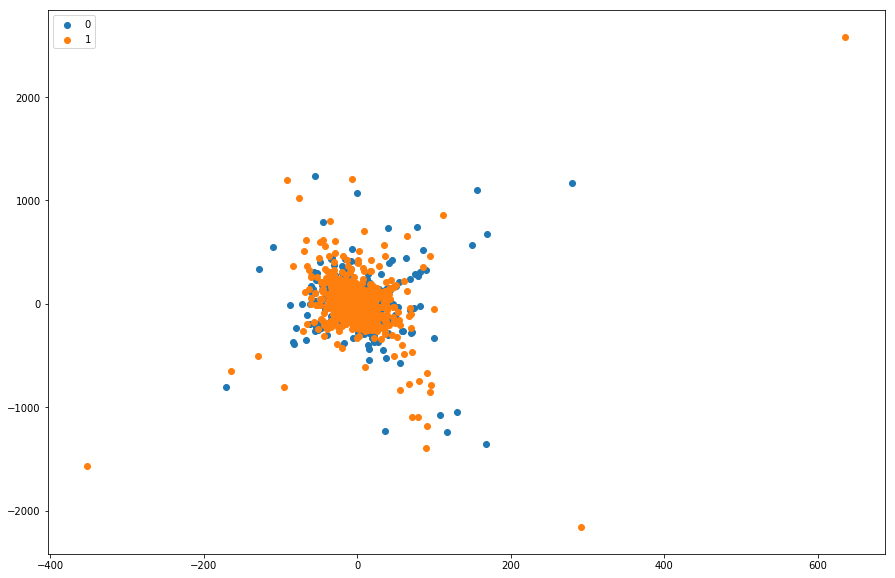

In [11]:
# Plotting the features after dimensionality reduction
plt.figure(figsize=(15,10))
plt.scatter(tgt_0["pca-two"], tgt_0["pca-one"], label="0")
plt.scatter(tgt_1["pca-two"], tgt_1["pca-one"], label="1")
plt.legend()
plt.show()

In [21]:
df["pca-one_sqr"] = pca_result[:,0]**3
df["pca-two_sqr"] = pca_result[:,1]**3

tgt_0 = df[df["Target"] == 0]
tgt_1 = df[df["Target"] == 1]

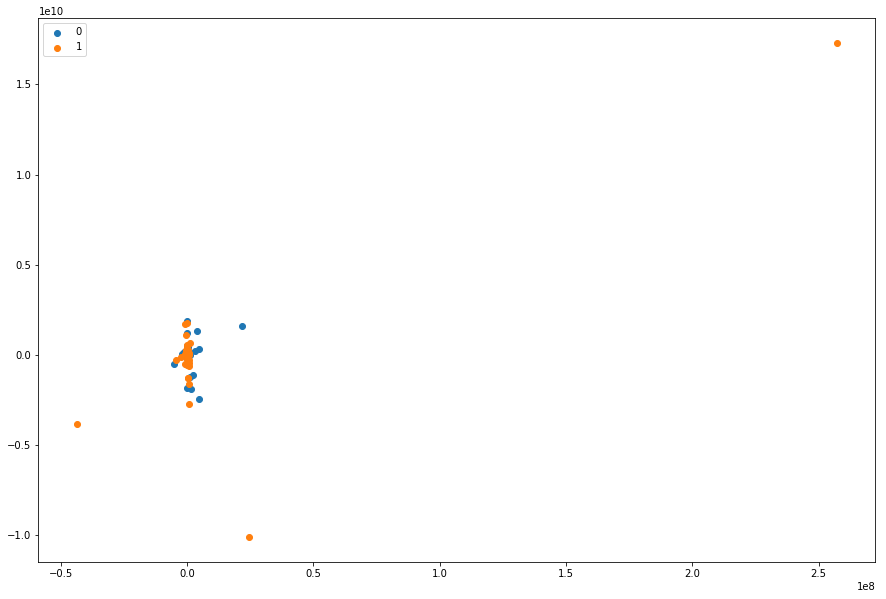

In [22]:
plt.figure(figsize=(15,10))
plt.scatter(tgt_0["pca-two_sqr"], tgt_0["pca-one_sqr"], label="0")
plt.scatter(tgt_1["pca-two_sqr"], tgt_1["pca-one_sqr"], label="1")
plt.legend()
plt.show()

### ii) T-SNE visualization :-

In [12]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=400)
tsne_results = tsne.fit_transform(df[feature_columns].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2888 samples in 0.001s...
[t-SNE] Computed neighbors for 2888 samples in 0.114s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2888
[t-SNE] Computed conditional probabilities for sample 2000 / 2888
[t-SNE] Computed conditional probabilities for sample 2888 / 2888
[t-SNE] Mean sigma: 4.570725
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.399200
[t-SNE] KL divergence after 400 iterations: 0.524148
t-SNE done! Time elapsed: 9.569404602050781 seconds


In [13]:
df["tsne-one"] = tsne_results[:,0]
df["tsne-two"] = tsne_results[:,1]

tgt_0 = df[df["Target"] == 0]
tgt_1 = df[df["Target"] == 1]

print(tgt_0.shape, tgt_1.shape)

(1336, 21) (1552, 21)


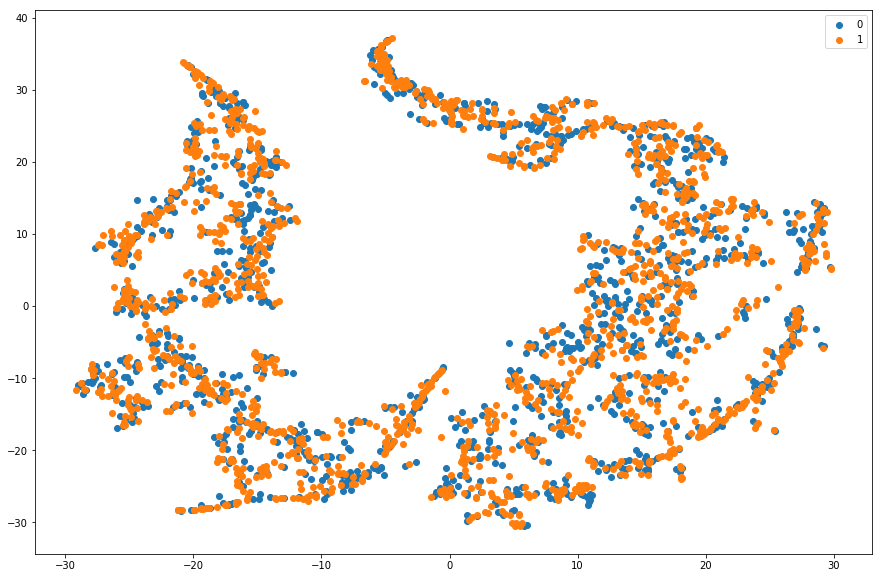

In [14]:
plt.figure(figsize=(15,10))
plt.scatter(tgt_0["tsne-two"], tgt_0["tsne-one"], label="0")
plt.scatter(tgt_1["tsne-two"], tgt_1["tsne-one"], label="1")
plt.legend()
plt.show()

## Data preparation :-

In [15]:
# Some dates must be missing in either of them
df.shape

(2888, 21)

In [16]:
not_feats = ["Date","High","Low","Open","Close","Volume","Adj Close","return","ret_pct", 
             "Target","MonthDay","Month","pca-one","pca-two","tsne-one","tsne-two"]
feature_columns = list(set(df.columns.values) - set(not_feats))

X = df[feature_columns]
y = df.Target.values

X.shape, y.shape

((2888, 5), (2888,))

In [17]:
X.head(3)

,Stock_gap,BankNiftySpot_gap,Month_enc,NiftySpot_gap,MonthDay_enc
1,0.212006,6.600586,0.567797,5.200195,0.494949
2,0.112991,6.350586,0.567797,3.549805,0.505051
3,1.462006,63.500000,0.567797,1.049805,0.578947


In [18]:
train_size = int(len(X)*0.8)
train_size

2310

In [19]:
X_train , X_test = X[0:train_size], X[train_size:]
y_train , y_test = y[0:train_size], y[train_size:]

## Applying ML models on data :-

In [20]:
seed = 2021

In [21]:
def get_highThresh_acc(y_pred_probs, y_test, thresh_prob=0.65):
    
    cnt, corr_predicts = 0, 0
    for i in range(len(y_test)):
        if y_pred_probs[i] > thresh_prob:    # Predict 1 (up move)
            cnt += 1
            if y_test[i] == 1:
                corr_predicts += 1
            else: pass
        elif y_pred_probs[i] < 1.0 - thresh_prob:    # Predict 0 (down move)
            cnt += 1
            if y_test[i] == 0:
                corr_predicts += 1
            else: pass
        else: continue
            
    print("Prediction accuracy : {}".format(corr_predicts/cnt))
    print("Percentage of datapoints predicted : {}".format(cnt/len(y_test)))
    print("No.of datapoints predicted : {}, Total datapoints : {}".format(cnt, len(y_test)))

    return

def get_highThresh_acc_lr(y_pred_probs, y_test, thresh_prob=0.65):
    
    cnt, corr_predicts = 0, 0
    for i in range(len(y_test)):
        
        if max(y_pred_probs[i]) > thresh_prob:
            cnt += 1
            if np.argmax(y_pred_probs[i]) == y_test[i]:
                corr_predicts += 1
                
    print("Accuracy with {} threshold : {}".format(thresh_prob, corr_predicts/cnt))
    print("Percentage of datapoints predicted : {}".format(cnt/len(y_test)))
    print("No.of datapoints predicted : {}, Total datapoints : {}".format(cnt, len(y_test)))

    return      

### Logistic Regression :-

In [26]:
# Create model
lr = LogisticRegression(random_state=seed)

# Prepare the cross-validation procedure
#cv = KFold(n_splits=5, random_state=seed, shuffle=True)
# Evaluate model
#scores = cross_val_score(lr, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# Report performance
#print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

# Fitting model to get probabs
lr.fit(X_train, y_train)
print("Accuracy with 0.5 threshold : {}".format(lr.score(X_test, y_test)))

y_pred_probabs = lr.predict_proba(X_test)
get_highThresh_acc_lr(y_pred_probabs, y_test, 0.65)

Accuracy with 0.5 threshold : 0.5432525951557093
Accuracy with 0.65 threshold : 0.8571428571428571
Percentage of datapoints predicted : 0.012110726643598616
No.of datapoints predicted : 7, Total datapoints : 578


c:\users\smitr\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### K-Nearest Neighbours :-

In [40]:
# Create model
neigh = KNeighborsClassifier(n_neighbors=5)
# Fit the model to data
neigh.fit(X_train, y_train)
print("Accuracy :- {}".format(neigh.score(X_test, y_test)))

Accuracy :- 0.5173010380622838


### Random Forest :-

In [27]:
# Prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=seed, shuffle=True)

# Create Random Forest model
rfc = RandomForestClassifier(n_estimators=10,
                              random_state=seed)
# Evaluate model
scores = cross_val_score(rfc, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [28]:
# Report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.489 (0.008)


In [28]:
#rfc.score(X_test, y_test)

0.5432525951557093

### XGBoost :-

In [44]:
import xgboost as xgb
from sklearn.metrics import precision_score

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify XGBoost parameters
params = {
    'max_depth': 5,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2}  # the number of classes that exist in this datset

# No.of training iterations
num_iters = 50  

# Create & Fit model
xg_boost = xgb.train(params, dtrain, num_iters)

# Predict classes for test set
preds = xg_boost.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])

# Print test accuracy
print("Accuracy :- {}".format(precision_score(y_test, best_preds, average='macro')))


Accuracy :- 0.5481851708074534


In [54]:
get_highThresh_acc_lr(preds, y_test, thresh_prob=0.86)

Accuracy with 0.86 threshold : 0.7105263157894737
Percentage of datapoints predicted : 0.0657439446366782
No.of datapoints predicted : 38, Total datapoints : 578


### Neural Network :-

In [29]:
fcnn = Sequential()
fcnn.add(Dense(8, input_dim=5, activation="relu"))
fcnn.add(Dense(4, activation="relu"))
fcnn.add(Dense(1, activation="sigmoid"))

fcnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 48        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Compiling the model
fcnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Defining callbacks
filepath="SBIN_move_predictor_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [31]:
fcnn.fit(X_train, y_train, epochs=30, 
         batch_size=16, validation_split=0.15)

Train on 1963 samples, validate on 347 samples
Epoch 1/30
1963/1963 [==============================] - 2s 809us/step - loss: 2.7688 - acc: 0.5099 - val_loss: 1.3821 - val_acc: 0.5072
Epoch 2/30
1963/1963 [==============================] - 0s 185us/step - loss: 0.7442 - acc: 0.4687 - val_loss: 0.8343 - val_acc: 0.4323
Epoch 3/30
1963/1963 [==============================] - 0s 179us/step - loss: 0.7053 - acc: 0.4733 - val_loss: 0.8040 - val_acc: 0.4179
Epoch 4/30
1963/1963 [==============================] - 0s 183us/step - loss: 0.7013 - acc: 0.4733 - val_loss: 0.7832 - val_acc: 0.4236
Epoch 5/30
1963/1963 [==============================] - 0s 181us/step - loss: 0.6981 - acc: 0.5018 - val_loss: 0.7684 - val_acc: 0.5533
Epoch 6/30
1963/1963 [==============================] - 0s 214us/step - loss: 0.6962 - acc: 0.5339 - val_loss: 0.7621 - val_acc: 0.5562
Epoch 7/30
1963/1963 [==============================] - 0s 179us/step - loss: 0.6954 - acc: 0.5344 - val_loss: 0.7529 - val_acc: 0.5533
E

In [32]:
y_pred = fcnn.predict_classes(X_test)
y_pred = np.squeeze(y_pred)

In [33]:
def get_test_acc(y_pred, y_test):
    
    correct = 0
    for i in range(len(y_pred)):
        if y_pred[i] == y_test[i]: correct += 1
        else: pass
        
    return 100*correct/len(y_pred)

print("Test set accuracy : {}".format(get_test_acc(y_pred, y_test)))

Test set accuracy : 53.97923875432526


In [ ]:
get_highThresh_acc(y_pred_probs, y_test, thresh_prob=0.85)

## Doing something which I wouldn't do with other type of data :-

In [26]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,return,Target,Stock_gap,MonthDay,Month,NiftySpot_gap,BankNiftySpot_gap,pca-one,pca-two,pca-one_sqr,pca-two_sqr,tsne-one,tsne-two
1,2007-12-04,221.240997,217.199005,219.557007,218.406006,8591649.0,64.989471,1.151001,1,0.212006,4,12,5.200195,6.600586,-12.680915,-0.119521,-2039.162246,-0.001707,-0.684587,-4.722948
2,2007-12-05,226.350998,218.080994,218.518997,224.983002,12728929.0,66.946533,-6.464005,0,0.112991,5,12,3.549805,6.350586,-13.325981,1.416836,-2366.451477,2.844192,-0.696000,-5.124694
3,2007-12-06,229.917007,224.464005,226.445007,226.024994,10837323.0,67.256592,0.420013,1,1.462006,6,12,1.049805,63.500000,41.511365,17.716836,71532.109918,5561.071321,-1.319524,16.016010
4,2007-12-07,231.889008,225.501007,228.785004,229.822998,10566995.0,68.386726,-1.037994,0,2.760010,7,12,8.899902,57.699219,37.806405,8.667229,54037.612279,651.089599,-0.393011,16.554722
5,2007-12-10,231.960007,227.860001,229.841995,228.893005,5373405.0,68.110001,0.948990,1,0.018997,10,12,-0.299805,4.100586,-16.446859,4.579593,-4448.862111,96.046305,-2.207004,-6.515734


In [27]:
X = df[["pca-one", "pca-two", "tsne-one", "tsne-two"]]
y = df.Target.values

train_size = int(len(X)*0.8)

X_train , X_test = X[0:train_size], X[train_size:]
y_train , y_test = y[0:train_size], y[train_size:]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2310, 4) (578, 4)
(2310,) (578,)


In [29]:
# Prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=2021, shuffle=True)

# Create Random Forest model
rfc = RandomForestClassifier(n_estimators=10,
                              random_state=2021)
# Evaluate model
scores = cross_val_score(rfc, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

# Report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.478 (0.015)


In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

fcnn = Sequential()
fcnn.add(Dense(16, input_dim=4, activation="relu"))
fcnn.add(Dense(4, activation="relu"))
fcnn.add(Dense(1, activation="sigmoid"))

fcnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Compiling the model
fcnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Defining callbacks
filepath="SBIN_move_predictor_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

fcnn.fit(X_train_scaled, y_train, epochs=60, 
         batch_size=16, validation_split=0.15)

Train on 1963 samples, validate on 347 samples
Epoch 1/60
1963/1963 [==============================] - 1s 472us/step - loss: 0.6875 - acc: 0.5395 - val_loss: 0.6933 - val_acc: 0.5216
Epoch 2/60
1963/1963 [==============================] - 0s 218us/step - loss: 0.6871 - acc: 0.5410 - val_loss: 0.6934 - val_acc: 0.5187
Epoch 3/60
1963/1963 [==============================] - 0s 185us/step - loss: 0.6871 - acc: 0.5385 - val_loss: 0.6930 - val_acc: 0.5303
Epoch 4/60
1963/1963 [==============================] - 0s 188us/step - loss: 0.6871 - acc: 0.5390 - val_loss: 0.6933 - val_acc: 0.5360
Epoch 5/60
1963/1963 [==============================] - 0s 195us/step - loss: 0.6869 - acc: 0.5395 - val_loss: 0.6929 - val_acc: 0.5274
Epoch 6/60
1963/1963 [==============================] - 0s 210us/step - loss: 0.6869 - acc: 0.5369 - val_loss: 0.6933 - val_acc: 0.5245
Epoch 7/60
1963/1963 [==============================] - 0s 210us/step - loss: 0.6869 - acc: 0.5380 - val_loss: 0.6937 - val_acc: 0.5101
E